In [1]:
from tensorflow.keras.models import load_model
from nn.data.datasets import get_rnn_sine
from matplotlib.pyplot import subplots
import numpy as np
import h5py
import json

# DATASET

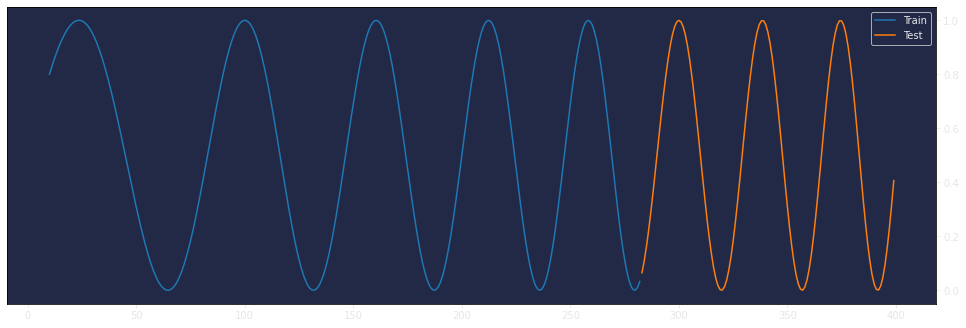

In [2]:
l_results = get_rnn_sine(step_back=10)
x_train, y_train, r_train, x_test, y_test, r_test = l_results

fig , ax = subplots(figsize=(15,5))
ax.plot(r_train,y_train, label = 'Train')
ax.plot(r_test,y_test, label = 'Test')
ax.legend();

# LOAD

In [3]:
CMT_DIR = 'cmt_model/lstm_sine.h5'

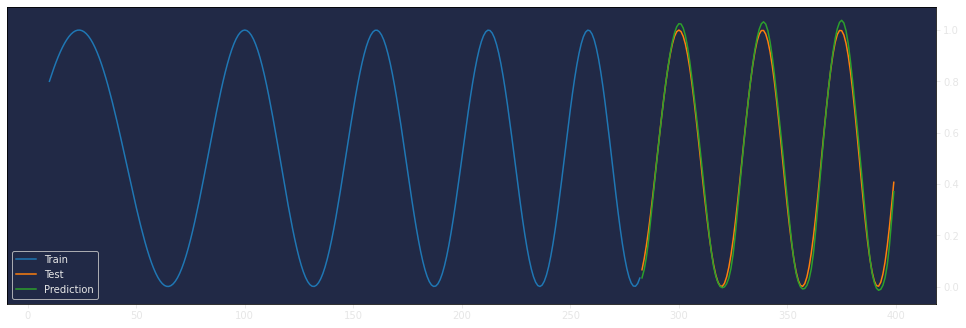

In [5]:
model_a = load_model( filepath = CMT_DIR , compile = True )
y_pred = model_a.predict( x = x_test )

fig , ax = subplots(figsize=(15,5))
ax.plot(r_train,y_train, label = 'Train')
ax.plot(r_test,y_test, label = 'Test')
ax.plot(r_test,y_pred, label = 'Prediction')
ax.legend();

# EXPLORATION

## H5 Attrs

In [6]:
cmt_data = h5py.File(CMT_DIR,'r')
# cmt_data.close()

In [13]:
print(cmt_data.attrs.keys())
print(cmt_data.attrs['backend'])
print(json.loads(cmt_data.attrs['training_config']).keys())
print(cmt_data.attrs['keras_version'])

<KeysViewHDF5 ['backend', 'keras_version', 'model_config', 'training_config']>
tensorflow
dict_keys(['loss', 'metrics', 'weighted_metrics', 'loss_weights', 'optimizer_config'])
2.7.0


### Model Configuration

In [17]:
d_model_config = json.loads( cmt_data.attrs['model_config'] )
print(d_model_config)

{'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 10, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'lstm_1_input'}}, {'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'batch_input_shape': [None, 10, 1], 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 4, 'activation': 'softsign', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0, 'stddev': 0.05, 'seed': 1}}, 'recurrent_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0, 'stddev': 0.05, 'seed': 1}}, 'bias_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0, 'stddev': 0.05, 'seed': 1}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None,

In [22]:
print(d_model_config.keys())
print(d_model_config['class_name'])
print(d_model_config['config'].keys())

dict_keys(['class_name', 'config'])
Sequential
dict_keys(['name', 'layers'])


In [28]:
# [ x.keys() for x in model_config['config']['layers']]
[ x['class_name'] for x in d_model_config['config']['layers']]

['InputLayer', 'LSTM', 'Dense']

## LSTM Layer

In [31]:
# batch_input_shape : [ None, 10, 1 ]
# return_state : False
# stateful : False
# activation : 'softsign'
# units : 4
# recurrent_activation : 'sigmoid'
# use_bias : boolean
# unit_forget_bias : True
model_config['config']['layers'][1]['config']

{'name': 'lstm_1',
 'trainable': True,
 'batch_input_shape': [None, 10, 1],
 'dtype': 'float32',
 'return_sequences': False,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'time_major': False,
 'units': 4,
 'activation': 'softsign',
 'recurrent_activation': 'sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0, 'stddev': 0.05, 'seed': 1}},
 'recurrent_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0, 'stddev': 0.05, 'seed': 1}},
 'bias_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0, 'stddev': 0.05, 'seed': 1}},
 'unit_forget_bias': True,
 'kernel_regularizer': None,
 'recurrent_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'recurrent_constraint': None,
 'bias_constraint': None,
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'implementation': 2}

In [ ]:
""" 'name', 'batch_input_shape', 'dtype', 'units', 'activation', 'use_bias' """

In [120]:
l_layers_cnf = []
l_keys = ['name','units','dtype','activation','use_bias']

for layer in model_config['config']['layers']:
    l_cnf = layer['config']
    class_name = layer['class_name']
    print('\n',class_name,':')
    if class_name == 'InputLayer' :
        print('  ',l_cnf['name'], l_cnf['batch_input_shape'], l_cnf['dtype'])
    else:
        d_cnf = { k : l_cnf[k] for k in l_keys }
        print('  ', *list(d_cnf.values()))
        # print('  ',l_cnf['name'], l_cnf['units'], l_cnf['dtype'], l_cnf['activation'], l_cnf['use_bias'])
        l_layers_cnf.append(d_cnf)
    # print('  ',layer['config'].keys())


 InputLayer :
   hidden_1_input [None, 2] float32

 Dense :
   hidden_1 10 float32 sigmoid True

 Dense :
   output 1 float32 linear False


## Weights

In [121]:
cmt_data['model_weights'].keys()

<KeysViewHDF5 ['hidden_1', 'output', 'top_level_model_weights']>

## NUMPY MODEL

## Weights & Acts

In [122]:
d_model_weights = cmt_data['model_weights']
l_w, l_b, l_a = [], [], []

for layer_cnf in l_layers_cnf:
    name = layer_cnf['name']
    activation = layer_cnf['activation']
    d_weights = d_model_weights[name][name]
    
    kernel = d_weights['kernel:0'][:]
    bias = d_weights['bias:0'][:] if layer_cnf['use_bias'] else 0

    l_w.append(kernel)
    l_b.append(bias)
    l_a.append(activation)

### ACTIVATION FUNCS

In [123]:
file = open('activations.py','r')
s_code_act = file.read()
file.close()
s_code_act

'import numpy as np\n\nlinear = lambda x : x\nrelu = lambda x : np.maximum(0,x)\nsigmoid = lambda x : 1/(1 + np.exp(-x))\n'

## Functions Regex

In [124]:
import re

def get_act_fnc(l_a):
    string = ''
    for activation in set(l_a):
        pattern = activation + r'.*'
        result = re.search(pattern,s_code_act)
        if result:
            string += result.group() + '\n'
            
    string += '\nd_act = { ' + ', '.join([ f"'{act}' : {act}" for act in set(l_a)]) + ' }\n\n'
    return string

print(get_act_fnc(l_a))

linear = lambda x : x
sigmoid = lambda x : 1/(1 + np.exp(-x))

d_act = { 'linear' : linear, 'sigmoid' : sigmoid }




### FEEDFORWARD

In [125]:
exec(get_act_fnc(l_a))

output = x_sample

for w,b,act in zip(l_w,l_b,l_a):
    f_act = d_act[act]
    output = f_act(output.dot(w) + b)

print(output)

[[ 0.09024292]
 [ 1.1006538 ]
 [ 1.32896663]
 [-0.35731253]]


# NUMPY CLASS

## MODEL FILE GENERATION

In [126]:
s_code = 'import numpy as np\n\n'
s_code += get_act_fnc(l_a)
s_code += f'l_w = {str(list(map(lambda w : w.tolist(), l_w)))}\n\n'
s_code += f'l_b = {str(list(map(lambda b : b if type(b) is int else b.tolist(), l_b)))}\n\n'
s_code += f'l_a = {str(l_a)}\n'

s_code += f'l_w = list(map(np.array,l_w))\n'
s_code += f'l_b = list(map(lambda x : np.array(x) if type(x) is list else x, l_b))\n'
                       
s_code += f'''
def feedforward(x):
    output = x.copy()
    for w,b,act in zip(l_w,l_b,l_a):
        f_act = d_act[act]
        output = f_act(output.dot(w) + b)
    return output
'''
print(s_code)

file = open('model.py', 'w')
file.write(s_code)
file.close()

import numpy as np

linear = lambda x : x
sigmoid = lambda x : 1/(1 + np.exp(-x))

d_act = { 'linear' : linear, 'sigmoid' : sigmoid }

l_w = [[[-0.5692449808120728, 7.034882068634033, 0.8901565670967102, -1.2982566356658936, -7.78250789642334, -0.596753716468811, -3.094672679901123, 0.4607388377189636, -0.5057770609855652, -0.3972644507884979], [-0.9048697352409363, 6.902655124664307, 1.6131205558776855, -0.23207269608974457, 5.748035907745361, -0.43503740429878235, 5.758194923400879, 2.4055724143981934, -1.5594075918197632, -1.570223331451416]], [[0.12166593223810196], [1.637164831161499], [-0.4853067398071289], [0.09327518194913864], [1.5986828804016113], [0.031022746115922928], [-1.3279681205749512], [-0.7030462622642517], [0.2715253531932831], [0.3019183874130249]]]

l_b = [[-0.07483713328838348, -4.254740238189697, -0.608847975730896, -0.5387024283409119, -0.8356730341911316, -0.22868682444095612, -0.4641977548599243, -1.3353506326675415, 0.20014885067939758, 0.09103742241859436],

## MODEL FILE TEST

In [127]:
import model

In [128]:
model.feedforward(x = x_sample)

array([[ 0.09024292],
       [ 1.1006538 ],
       [ 1.32896663],
       [-0.35731253]])